# Introdução

Esse caderno tem por objetivo a criação de um modelo básico de treinamento, utilizando o classificador [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), que faça a predição de homologação de arquivamentos de procedimentos enviados à 1A.CAM do MPF.

Esse modelo usará apenas os metadados dos procedimentos, sem fazer nenhum processamento textual.

O objetivo desse modelo é servir como um *baseline* de comparações para implementações futuras.


**Nota**: os dados desse modelo foram recuperados de procedimentos que tiveram suas deliberações realizadas após o dia 02/07/2018, data em que a nova composição tomou posse na 1A.CAM.

# Carga de dados e pré-processamento

Vamos fazer a carga dos dados e fazer um pré-processamento tradicional (remoção de atributos que não interessam, criação de variáveis categóricas etc.)

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

from sklearn import metrics

In [3]:
PATH = "../data/"
df_original = pd.read_json(f'{PATH}/1A.CAM.homologacao-arquivamento.json')

In [4]:
len(df_original)

8401

In [5]:
df_original.columns

Index(['areaAtuacao', 'classe', 'dataAutuacao', 'dataEntrada', 'homologado',
       'id', 'identificadorPecaPromocao', 'itemCnmp', 'membroResponsavel',
       'municipio', 'prioritario', 'procedimento', 'quantidadeConversoes',
       'quantidadeProvidencias', 'textosProvidencias', 'urgente'],
      dtype='object')

In [6]:
df_original.describe()

,areaAtuacao,classe,homologado,id,identificadorPecaPromocao,itemCnmp,membroResponsavel,municipio,prioritario,quantidadeConversoes,quantidadeProvidencias,urgente
count,8.401000e+03,8401.000000,8401.000000,8.401000e+03,7.443000e+03,8.401000e+03,7443.000000,8401.000000,8401.000000,8401.000000,8401.000000,8401.000000
mean,2.403226e+02,2.542912,0.984050,6.885354e+07,8.024042e+07,3.618624e+04,39114.090152,2923.952506,0.007023,2.077372,7.311749,0.007737
std,2.182139e+04,1.460381,0.125291,1.361934e+07,6.839434e+06,2.602520e+05,34816.543692,1670.038202,0.083513,1.460256,8.735195,0.087625
min,1.000000e+00,1.000000,0.000000,2.842880e+06,5.388574e+07,2.000000e+00,752.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000e+00,2.000000,1.000000,6.441073e+07,7.483514e+07,1.521000e+03,13674.000000,1443.000000,0.000000,1.000000,2.000000,0.000000
50%,2.000000e+00,3.000000,1.000000,7.140668e+07,8.117652e+07,1.581000e+03,25849.000000,3087.000000,0.000000,2.000000,5.000000,0.000000
75%,2.000000e+00,3.000000,1.000000,7.779927e+07,8.650883e+07,1.911000e+03,53328.000000,4385.000000,0.000000,3.000000,9.000000,0.000000
max,2.000085e+06,64.000000,1.000000,8.944926e+07,8.971058e+07,2.007548e+06,128455.000000,5768.000000,1.000000,13.000000,192.000000,1.000000


In [7]:
len(df_original[df_original.identificadorPecaPromocao.isnull()])

958

In [8]:
df_work = df_original.copy()

In [9]:
# nessa primeira passada, essas colunas não nos interessam
removed_columns = ['id', 'procedimento', 'textosProvidencias', 'identificadorPecaPromocao']
df_work = df_work.drop(columns=removed_columns)
df_work.sample(10)

,areaAtuacao,classe,dataAutuacao,dataEntrada,homologado,itemCnmp,membroResponsavel,municipio,prioritario,quantidadeConversoes,quantidadeProvidencias,urgente
4481,2,3,17-02-2014,17-08-2017,1,1870,53281.0,5055,0,2,4,0
480,2,3,01-09-2017,24-09-2018,1,3150,53252.0,1309,0,3,12,0
4513,2,3,19-08-2016,07-08-2017,1,1521,NaN,3689,0,3,14,0
1942,2,2,18-04-2018,11-07-2018,1,1523,9394.0,3353,0,1,3,0
5864,2,2,19-02-2016,21-02-2017,1,1521,17599.0,5160,0,1,5,0
4721,5,3,29-07-2014,13-07-2017,1,3119,64361.0,5169,0,3,15,0
4308,2,3,15-05-2015,14-09-2017,1,2029,20666.0,4838,0,4,9,0
8024,2,2,28-10-2015,25-01-2016,1,1507,4043.0,810,0,0,1,0
6876,2,2,20-07-2016,13-09-2016,1,1560,10297.0,810,1,0,2,1
2825,2,3,27-07-2016,21-05-2018,1,2359,23247.0,1996,0,2,4,0


In [10]:
df_work.describe()

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,prioritario,quantidadeConversoes,quantidadeProvidencias,urgente
count,8.401000e+03,8401.000000,8401.000000,8.401000e+03,7443.000000,8401.000000,8401.000000,8401.000000,8401.000000,8401.000000
mean,2.403226e+02,2.542912,0.984050,3.618624e+04,39114.090152,2923.952506,0.007023,2.077372,7.311749,0.007737
std,2.182139e+04,1.460381,0.125291,2.602520e+05,34816.543692,1670.038202,0.083513,1.460256,8.735195,0.087625
min,1.000000e+00,1.000000,0.000000,2.000000e+00,752.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000e+00,2.000000,1.000000,1.521000e+03,13674.000000,1443.000000,0.000000,1.000000,2.000000,0.000000
50%,2.000000e+00,3.000000,1.000000,1.581000e+03,25849.000000,3087.000000,0.000000,2.000000,5.000000,0.000000
75%,2.000000e+00,3.000000,1.000000,1.911000e+03,53328.000000,4385.000000,0.000000,3.000000,9.000000,0.000000
max,2.000085e+06,64.000000,1.000000,2.007548e+06,128455.000000,5768.000000,1.000000,13.000000,192.000000,1.000000


In [11]:
# tratando os nulos
df_work.fillna(0, inplace=True)

In [12]:
len(df_work[df_work['homologado'] == 1]),len(df_work[df_work['homologado'] == 0])

(8267, 134)

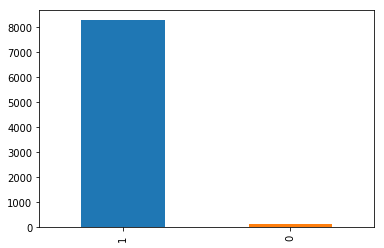

In [13]:
df_work['homologado'].value_counts().plot.bar()

### Classes desbalanceadas!!!

Conforme podemos ver acima, as classes desse problema são altamente desbalanceadas - apenas 1.46% do conjunto de dados representam procedimentos que não foram homologados.

Isso, muito provavelmente, causará problemas no treino do modelo. Mas, inicialmente, vamos ignorar isso e seguir com o nosso treino.

In [14]:
# conversão para datas
df_work['dataAutuacao'] = pd.to_datetime(df_work['dataAutuacao'],infer_datetime_format=True)
df_work['dataEntrada'] = pd.to_datetime(df_work['dataEntrada'],infer_datetime_format=True)

In [15]:
# vamos criar uma variável derivada, representando a quantidade de dias desde a autuação até a entrada
df_work['diasTranscorridos'] = 0
for index in range(len(df_work)):
    df_work.loc[index, 'diasTranscorridos'] =  np.abs((df_work.loc[index, 'dataEntrada'] - df_work.loc[index, 'dataAutuacao']).days)

In [16]:
df_work.sample(10)

,areaAtuacao,classe,dataAutuacao,dataEntrada,homologado,itemCnmp,membroResponsavel,municipio,prioritario,quantidadeConversoes,quantidadeProvidencias,urgente,diasTranscorridos
3316,2,3,2017-08-10,2018-04-13,1,3147,8883.0,4053,0,2,7,0,246
641,5,2,2017-08-29,2018-09-12,1,2830,64361.0,3803,0,1,3,0,379
5846,2,3,2014-04-01,2017-02-21,1,1556,26482.0,3281,0,3,8,0,1057
7648,2,2,2015-11-20,2016-04-07,1,1514,53327.0,1619,0,1,6,0,139
5407,2,3,2014-03-14,2017-04-07,1,692,53318.0,3530,0,5,13,0,1120
6532,5,2,2016-06-03,2016-11-23,1,1556,3054.0,3009,0,1,3,0,173
1606,2,3,2016-03-30,2018-07-26,1,1564,23277.0,4580,0,3,6,0,848
6705,2,3,2016-02-23,2016-10-07,1,652,31459.0,3102,0,3,8,0,227
6440,2,3,2016-07-21,2016-12-01,0,1569,23549.0,4584,0,1,1,0,133
5998,2,3,2016-08-10,2017-02-13,1,1488,0.0,285,0,1,1,0,187


In [17]:
removed_columns = ['homologado', 'dataEntrada', 'dataAutuacao']
features = [c for c in df_work.columns if c not in removed_columns]

model = RandomForestClassifier(random_state=42)
model.fit(df_work[features], df_work['homologado'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [18]:
model.score(df_work[features], df_work['homologado'])

0.997738364480419

In [19]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df_work, random_state=42)
train.shape, valid.shape

((6300, 13), (2101, 13))

In [20]:
model.fit(train[features], train['homologado'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [21]:
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_score():
    print('Accuracy score:', accuracy_score(train['homologado'], train_preds), accuracy_score(valid['homologado'], valid_preds))
    print('Precision score: ', format(precision_score(valid['homologado'], valid_preds)))
    print('Recall score: ', format(recall_score(valid['homologado'], valid_preds)))
    print('F1 score: ', format(f1_score(valid['homologado'], valid_preds)))

print_score()

Accuracy score: 0.9985714285714286 0.9861970490242742
Precision score:  0.9876013352408202
Recall score:  0.9985535197685632
F1 score:  0.9930472308798849


### Primeira avaliação

Embora não tenha ocorrido overfitting no treinamento e o *score* final tenha sido alto, cabe utilizar uma outra medida para assegurar a qualidade do modelo. Vamos utilizar a ** *matriz de confusão* **.



In [23]:
from sklearn.metrics import confusion_matrix

confusion_matrix(valid['homologado'], valid_preds)

array([[   1,   26],
       [   3, 2071]], dtype=int64)

In [24]:
len(valid[valid['homologado']==1]), len(valid[valid['homologado']==0])

(2074, 27)

Logo, apesar da acurácia do modelo aparentar ser muito boa (98% no validation set), o **modelo não sabe lidar com os não arquivamentos** - não acertou nenhum dos que realmente não foram homologados. Ou seja dos 28 que não foram homologados, o modelo errou todos.

Fica claro que somente essas features não ajudam na descoberta - o texto da íntegra é, segundo a área negocial, realmente o mais importante.

Vamos continuar avaliando esse modelo.

## Feature importances

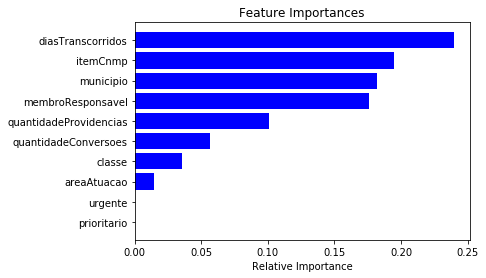

In [25]:
import matplotlib.pyplot as plt

def plot_fi(feature_importances, size=None):
    feature_importances = model.feature_importances_
    
    if not size:
        size = len(feature_importances)
    
    indices = np.argsort(feature_importances[0:size])
    
    plt.title('Feature Importances')
    plt.barh(range(size), feature_importances[indices], color='b', align='center')
    plt.yticks(range(size), [features[i] for i in indices if i < size])
    plt.xlabel('Relative Importance')
    plt.show()
    
plot_fi(model.feature_importances_)

O modelo está dando muita importância ao município que, considerando o bom senso e um pouco de domínio negocial, não faz sentido - o município não deveria interferir.

Lembrar: criar uma coluna para cada uma das listas de palavras-chaves, indicando ausência ou presença

In [26]:
# Vou retirar as colunas com poucas importância
removed_columns = ['homologado', 'dataEntrada', 'dataAutuacao', 'urgente', 'prioritario']
features = [c for c in df_work.columns if c not in removed_columns]

model = RandomForestClassifier(random_state=42)

model.fit(train[features], train['homologado'])

train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9985714285714286 0.9861970490242742
Precision score:  0.9871367317770366
Recall score:  0.9990356798457087
F1 score:  0.993050563144021


In [27]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   2, 2072]], dtype=int64)

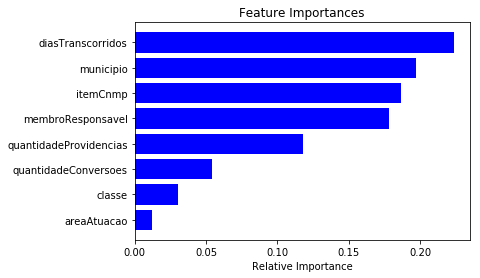

In [28]:
plot_fi(model.feature_importances_)

Com as novas features, retirando a urgente e a prioritário, não houve melhorias.

Vou retirar a coluna município, pois, ao meu ver, ela não nos parece adequada - e o modelo continua dando muita importância a ela.

In [29]:
removed_columns.append('municipio')
removed_columns

features = [c for c in df_work.columns if c not in removed_columns]

model.fit(train[features], train['homologado'])

train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9985714285714286 0.9861970490242742
Precision score:  0.9876013352408202
Recall score:  0.9985535197685632
F1 score:  0.9930472308798849


In [30]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   1,   26],
       [   3, 2071]], dtype=int64)

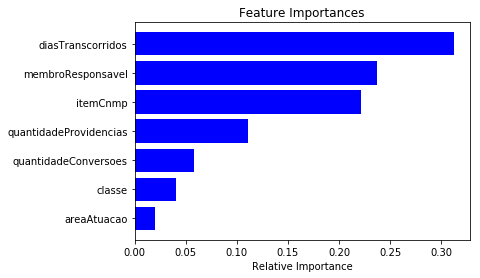

In [31]:
plot_fi(model.feature_importances_)

Ao retirar a coluna município, fez com que aparece um true negative e um false positive.

Vamos criar um modelo ainda mais simples, apenas com as features cuja importância seja maior que 5%.

In [32]:
model = RandomForestClassifier(random_state=42)

important_features = ['membroResponsavel', 'diasTranscorridos', 'itemCnmp', 'quantidadeProvidencias', 'quantidadeConversoes']
model.fit(train[important_features], train['homologado'])

train_preds = model.predict(train[important_features])
valid_preds = model.predict(valid[important_features])

print_score()

Accuracy score: 0.9985714285714286 0.985721085197525
Precision score:  0.9871306005719733
Recall score:  0.9985535197685632
F1 score:  0.9928092042186002


In [33]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   3, 2071]], dtype=int64)

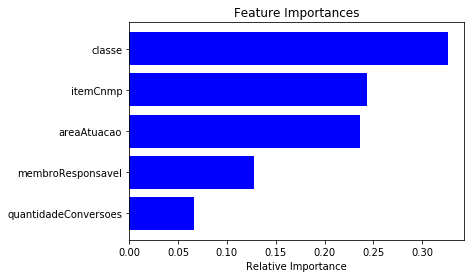

In [34]:
plot_fi(model.feature_importances_)

Somente com as features importantes acima, o desempenho se manteve. 

Interessante notar que a variável diasTranscorridos desapereceu da lista de importâncias.

Vamos fazer mais um teste, apenas com as top-3 features

In [35]:
important_features = ['classe', 'areaAtuacao', 'itemCnmp']

model = RandomForestClassifier(random_state=42)
model.fit(train[important_features], train['homologado'])

train_preds = model.predict(train[important_features])
valid_preds = model.predict(valid[important_features])

print_score()

Accuracy score: 0.9865079365079366 0.9809614469300333
Precision score:  0.987535953978907
Recall score:  0.9932497589199615
F1 score:  0.9903846153846154


In [36]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   1,   26],
       [  14, 2060]], dtype=int64)

Com o modelo mais simples, a acurácia caiu e apareceram false negatives. 

Fica claro que não sabe lidar com os não homologados.

Vamos passar a considerar o texto das providências.

## Considerando as providências realizadas

In [37]:
df_work = df_original.copy()

df_work['dataAutuacao'] = pd.to_datetime(df_work['dataAutuacao'],infer_datetime_format=True)
df_work['dataEntrada'] = pd.to_datetime(df_work['dataEntrada'],infer_datetime_format=True)

df_work['diasTranscorridos'] = 0
for index in range(len(df_work)):
    df_work.loc[index, 'diasTranscorridos'] =  np.abs((df_work.loc[index, 'dataEntrada'] - df_work.loc[index, 'dataAutuacao']).days)

removed_columns = ['id', 'procedimento', 'identificadorPecaPromocao', 'prioritario', 'urgente', 'dataAutuacao', 'dataEntrada']
df_work = df_work.drop(columns=removed_columns)
df_work.fillna(0, inplace=True)

    
df_work.sample(10)

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,quantidadeConversoes,quantidadeProvidencias,textosProvidencias,diasTranscorridos
5225,2,2,1,1772,8698.0,3019,1,3,"Oficie-se,Converta-se em Procedimento Preparat...",154
1552,2,2,1,1753,18851.0,1027,2,7,"Oficie-se.,Prorroga-se o prazo de finalização ...",140
1409,2,2,1,1678,18814.0,2599,1,2,"Oficie-se.,Converta-se em Procedimento Prepara...",134
8390,2,3,1,1479,31460.0,3035,3,23,"Encaminhe-se o auto.,Oficie-se.,Prorroga-se o ...",1833
3443,2,2,1,1506,23992.0,5459,1,9,"Despacho Simplificado,Oficie-se.,Desentranha-s...",129
8109,2,3,1,750,23212.0,2211,2,12,"Encaminhe-se o auto.,Converta-se em Inquérito ...",385
4882,2,3,1,3150,127530.0,240,1,2,"Converta-se em Inquérito Civil(IC).,Oficie-se.",342
1727,2,2,1,1507,10297.0,810,1,2,"Oficie-se.,Converta-se em Procedimento Prepara...",303
4888,2,2,1,1102,9643.0,3689,2,5,"Analisar Arquivamento,Oficie-se.,Prorroga-se o...",418
8206,2,3,1,1852,0.0,4313,1,17,"Analisar Arquivamento,Junte-se.,Oficie-se.,Pro...",785


In [38]:
df_work.describe()

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,quantidadeConversoes,quantidadeProvidencias,diasTranscorridos
count,8.401000e+03,8401.000000,8401.000000,8.401000e+03,8401.000000,8401.000000,8401.000000,8401.000000,8401.000000
mean,2.403226e+02,2.542912,0.984050,3.618624e+04,34653.752291,2923.952506,2.077372,7.311749,581.627068
std,2.182139e+04,1.460381,0.125291,2.602520e+05,35050.392009,1670.038202,1.460256,8.735195,613.894433
min,1.000000e+00,1.000000,0.000000,2.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.000000e+00,2.000000,1.000000,1.521000e+03,8883.000000,1443.000000,1.000000,2.000000,174.000000
50%,2.000000e+00,3.000000,1.000000,1.581000e+03,23212.000000,3087.000000,2.000000,5.000000,343.000000
75%,2.000000e+00,3.000000,1.000000,1.911000e+03,53307.000000,4385.000000,3.000000,9.000000,789.000000
max,2.000085e+06,64.000000,1.000000,2.007548e+06,128455.000000,5768.000000,13.000000,192.000000,5823.000000


In [39]:
listaProvidencias = []
for index in range(len(df_work)):
    for s in str(df_work['textosProvidencias'][index]).strip().lower().split(','):
        listaProvidencias.append(s)

listaProvidencias = set(listaProvidencias)
listaProvidencias.remove('análise do arquivamento')
listaProvidencias.remove('analisar arquivamento')
listaProvidencias.remove('arquive-se na unidade.')

In [40]:
df_work = pd.concat([df_work, pd.get_dummies(sorted(list(listaProvidencias)), drop_first=True)], axis=1)

In [41]:
for index in range(len(df_work)):
    for s in str(df_work.textosProvidencias[index]).strip().split(','):
        df_work.at[index, s.lower()] = 1

In [42]:
df_work.describe()

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,quantidadeConversoes,quantidadeProvidencias,diasTranscorridos,analisar conflito de atribuição,...,recomende-se.,redistribua-se.,requisite-se perícia à ccr/mpf.,sobrestar no setor.,solicitar instauração de inquérito judicial,vistoria,análise do arquivamento,analisar arquivamento,arquive-se na unidade.,
count,8.401000e+03,8401.000000,8401.000000,8.401000e+03,8401.000000,8401.000000,8401.000000,8401.000000,8401.000000,137.000000,...,737.000000,809.000000,89.000000,1022.000000,74.000000,86.000000,238.0,886.0,159.0,175.0
mean,2.403226e+02,2.542912,0.984050,3.618624e+04,34653.752291,2923.952506,2.077372,7.311749,581.627068,0.481752,...,0.910448,0.927070,0.191011,0.946184,0.027027,0.162791,1.0,1.0,1.0,1.0
std,2.182139e+04,1.460381,0.125291,2.602520e+05,35050.392009,1670.038202,1.460256,8.735195,613.894433,0.501501,...,0.285733,0.260182,0.395325,0.225765,0.163269,0.371340,0.0,0.0,0.0,0.0
min,1.000000e+00,1.000000,0.000000,2.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0
25%,2.000000e+00,2.000000,1.000000,1.521000e+03,8883.000000,1443.000000,1.000000,2.000000,174.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.0,1.0,1.0,1.0
50%,2.000000e+00,3.000000,1.000000,1.581000e+03,23212.000000,3087.000000,2.000000,5.000000,343.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.0,1.0,1.0,1.0
75%,2.000000e+00,3.000000,1.000000,1.911000e+03,53307.000000,4385.000000,3.000000,9.000000,789.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.0,1.0,1.0,1.0
max,2.000085e+06,64.000000,1.000000,2.007548e+06,128455.000000,5768.000000,13.000000,192.000000,5823.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0


In [43]:
df_work.head()

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,quantidadeConversoes,quantidadeProvidencias,textosProvidencias,diasTranscorridos,...,recomende-se.,redistribua-se.,requisite-se perícia à ccr/mpf.,sobrestar no setor.,solicitar instauração de inquérito judicial,vistoria,análise do arquivamento,analisar arquivamento,arquive-se na unidade.,
0,2,3,1,1708,10687.0,810,3,6,"Converta-se em Inquérito Civil(IC).,Oficie-se....",383,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,2,3,1,1503,96733.0,253,8,16,"Prorroga-se Expediente.,Justificativa para fin...",2520,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,2,2,1,1521,31435.0,3193,3,7,"Despacho Simplificado,Oficie-se.,Prorroga-se o...",328,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,2,3,1,1580,5262.0,3422,7,31,"Apense-se.,Sobrestar no setor.,Notifique-se.,O...",3085,...,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
4,2,2,1,1507,87450.0,4842,3,15,"Sobrestar no setor.,Oficie-se.,Prorroga-se o p...",225,...,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN


In [44]:
df_work.fillna(0, inplace=True)

In [45]:
removed_columns = ['homologado', 'textosProvidencias']
features = [c for c in df_work.columns if c not in removed_columns]

In [46]:
train, valid = train_test_split(df_work, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(train[features], train['homologado'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [47]:
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9987301587301587 0.9871489766777725
Precision score:  0.9871489766777725
Recall score:  1.0
F1 score:  0.9935329341317366


In [48]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   0, 2074]], dtype=int64)

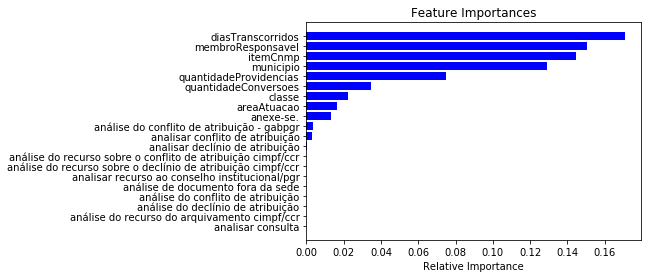

In [49]:
plot_fi(model.feature_importances_, 20)

O uso dos textos das providências não aumentou a precisão do modelo (e elas também não foram features importantes).

Vamos voltar ao modelo mais simples, sem os textos das providências e tentar melhorar os hiperparâmetros.

## Voltando ao modelo mais simples (sem considerar quais providências foram realizadas)

In [50]:
df_work = df_original.copy()

df_work['dataAutuacao'] = pd.to_datetime(df_work['dataAutuacao'],infer_datetime_format=True)
df_work['dataEntrada'] = pd.to_datetime(df_work['dataEntrada'],infer_datetime_format=True)

df_work['diasTranscorridos'] = 0
for index in range(len(df_work)):
    df_work.loc[index, 'diasTranscorridos'] =  np.abs((df_work.loc[index, 'dataEntrada'] - df_work.loc[index, 'dataAutuacao']).days)

removed_columns = ['id', 'procedimento', 'identificadorPecaPromocao', 'prioritario', 'urgente', 'dataAutuacao', 'dataEntrada']
df_work = df_work.drop(columns=removed_columns)
df_work.fillna(0, inplace=True)

    
df_work.sample(10)

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,quantidadeConversoes,quantidadeProvidencias,textosProvidencias,diasTranscorridos
455,2,2,1,1921,31453.0,2918,1,1,Converta-se em Procedimento Preparatório(PP).,112
157,2,3,1,1614,6111.0,2772,6,40,"Converta-se em Inquérito Civil(IC).,Certifica ...",1786
6779,2,3,1,1580,26482.0,3281,2,5,"Despacho Simplificado,Converta-se em Inquérito...",237
2762,2,1,0,1539,53245.0,5039,0,1,Oficie-se.,43
578,2,2,1,1811,26334.0,1018,1,1,Converta-se em Procedimento Preparatório(PP).,168
5895,2,2,1,1521,64259.0,2969,1,1,Converta-se em Procedimento Preparatório(PP).,354
1566,2,3,1,3147,27818.0,4878,4,5,"Converta-se em Inquérito Civil(IC).,Oficie-se....",811
7062,2,3,1,1569,8584.0,4387,3,24,"Sobrestar no setor.,Notifique-se.,Oficie-se,Of...",1477
5909,2,2,1,1863,0.0,1018,1,3,"Converta-se em Procedimento Preparatório(PP).,...",112
2554,2,3,1,1654,2663.0,3113,4,24,"Converta-se em Inquérito Civil(IC).,Junte-se.,...",777


In [51]:
removed_columns = ['homologado', 'textosProvidencias']
features = [c for c in df_work.columns if c not in removed_columns]

train, valid = train_test_split(df_work, random_state=42)

In [52]:
model = RandomForestClassifier(random_state=42, n_estimators=100); model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [53]:
model.fit(train[features], train['homologado'])

train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9998412698412699 0.9876249405045217
Precision score:  0.9876190476190476
Recall score:  1.0
F1 score:  0.9937709631049353


In [54]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   1,   26],
       [   0, 2074]], dtype=int64)

### Aumentando o número de árvores

In [55]:
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(train[features], train['homologado'])
confusion_matrix(valid['homologado'], valid_preds).ravel()
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9998412698412699 0.9876249405045217
Precision score:  0.9876190476190476
Recall score:  1.0
F1 score:  0.9937709631049353


In [56]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   1,   26],
       [   0, 2074]], dtype=int64)

In [57]:
model = RandomForestClassifier(random_state=42, n_estimators=1000)
model.fit(train[features], train['homologado'])
confusion_matrix(valid['homologado'], valid_preds).ravel()
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 1.0 0.9871489766777725
Precision score:  0.9871489766777725
Recall score:  1.0
F1 score:  0.9935329341317366


In [58]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   0, 2074]], dtype=int64)

In [59]:
model = RandomForestClassifier(random_state=42, n_estimators=2000)
model.fit(train[features], train['homologado'])
confusion_matrix(valid['homologado'], valid_preds).ravel()
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 1.0 0.9871489766777725
Precision score:  0.9871489766777725
Recall score:  1.0
F1 score:  0.9935329341317366


In [60]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   0, 2074]], dtype=int64)

Aumentar o número de árvores parece não melhorar a performance. Vamos para o número de features.

### Considerando o número de features

In [61]:
model = RandomForestClassifier(random_state=42); model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [62]:
model.fit(train[features], train['homologado'])
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9985714285714286 0.9861970490242742
Precision score:  0.9871367317770366
Recall score:  0.9990356798457087
F1 score:  0.993050563144021


In [63]:
model = RandomForestClassifier(random_state=42, max_features='sqrt')
model.fit(train[features], train['homologado'])
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9985714285714286 0.9861970490242742
Precision score:  0.9871367317770366
Recall score:  0.9990356798457087
F1 score:  0.993050563144021


In [64]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   2, 2072]], dtype=int64)

In [65]:
model = RandomForestClassifier(random_state=42, max_features='log2')
model.fit(train[features], train['homologado'])
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9985714285714286 0.985721085197525
Precision score:  0.9871306005719733
Recall score:  0.9985535197685632
F1 score:  0.9928092042186002


In [66]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   3, 2071]], dtype=int64)

In [67]:
model = RandomForestClassifier(random_state=42, max_features=0.3)
model.fit(train[features], train['homologado'])
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9985714285714286 0.9861970490242742
Precision score:  0.9871367317770366
Recall score:  0.9990356798457087
F1 score:  0.993050563144021


In [68]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   2, 2072]], dtype=int64)

O parâmetro max_features parece não melhorar a performance. Vamos para o min_samples_leaf.

### Checando o min_samples_leaf

In [69]:
model = RandomForestClassifier(random_state=42); model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [70]:
model.fit(train[features], train['homologado'])
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9985714285714286 0.9861970490242742
Precision score:  0.9871367317770366
Recall score:  0.9990356798457087
F1 score:  0.993050563144021


In [71]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   2, 2072]], dtype=int64)

In [72]:
model = RandomForestClassifier(random_state=42, min_samples_leaf=2)
model.fit(train[features], train['homologado'])
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9846031746031746 0.9871489766777725
Precision score:  0.9871489766777725
Recall score:  1.0
F1 score:  0.9935329341317366


In [73]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   0, 2074]], dtype=int64)

In [74]:
model = RandomForestClassifier(random_state=42, min_samples_leaf=5)
model.fit(train[features], train['homologado'])
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.983015873015873 0.9871489766777725
Precision score:  0.9871489766777725
Recall score:  1.0
F1 score:  0.9935329341317366


In [75]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   0, 2074]], dtype=int64)

In [76]:
model = RandomForestClassifier(random_state=42, min_samples_leaf=10)
model.fit(train[features], train['homologado'])
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.983015873015873 0.9871489766777725
Precision score:  0.9871489766777725
Recall score:  1.0
F1 score:  0.9935329341317366


In [77]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   0, 2074]], dtype=int64)

Uma vez mais, não houve melhoria no modelo ao tentar modificar o min_samples_leaf.

Vamos tentar uma última coisa, que é lidar com o fato de as classes serem desbalanceadas.

## Lidando com as classes desbalanceadas

https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

In [84]:
X_train, X_test, y_train, y_test = train_test_split(df_work[features], df_work['homologado'], random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6300, 8), (6300,), (2101, 8), (2101,))

In [85]:
from imblearn.over_sampling import SMOTE

print("Antes do OverSampling, #homologados - label '1': {}".format(sum(y_train==1)))
print("Antes do OverSampling, #não homoogados - label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

print('Depois do OverSampling, shape do train_X: {}'.format(X_train_res.shape))
print('Depois do OverSampling, shape do train_y: {} \n'.format(y_train_res.shape))

print("Depois do OverSampling, #homologados - label '1': {}".format(sum(y_train_res==1)))
print("Depois OverSampling, #não homoogados - label '0': {}".format(sum(y_train_res==0)))

Antes do OverSampling, #homologados - label '1': 6193
Antes do OverSampling, #não homoogados - label '0': 107 

Depois do OverSampling, shape do train_X: (12386, 8)
Depois do OverSampling, shape do train_y: (12386,) 

Depois do OverSampling, #homologados - label '1': 6193
Depois OverSampling, #não homoogados - label '0': 6193


In [86]:
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train_res, y_train_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [87]:
def print_score():
    print('Accuracy score:', accuracy_score(y_test, valid_preds))
    print('Precision score: ', format(precision_score(y_test, valid_preds)))
    print('Recall score: ', format(recall_score(y_test, valid_preds)))
    print('F1 score: ', format(f1_score(y_test, valid_preds)))

In [88]:
valid_preds = model.predict(X_test)
print_score()

Accuracy score: 0.9852451213707758
Precision score:  0.9871244635193133
Recall score:  0.9980713596914176
F1 score:  0.9925677295612563


In [89]:
confusion_matrix(y_test, valid_preds)

array([[   0,   27],
       [   4, 2070]], dtype=int64)